In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import tree

### 실습 과제 1. 데이터 불러온 후 종속변수 데이터 타입 변경, train_data : test_data = 8:2 split, random_state=1000
#### 종속변수는 'class', 독립변수는 나머지 변수

In [4]:
df = pd.read_csv('Hepatitis.csv')
df['class'] = df['class'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              80 non-null     int64  
 1   sex              80 non-null     int64  
 2   steriod          80 non-null     int64  
 3   antivirals       80 non-null     int64  
 4   fatigue          80 non-null     int64  
 5   mamaise          80 non-null     int64  
 6   anorexia         80 non-null     int64  
 7   liver big        80 non-null     int64  
 8   liver firm       80 non-null     int64  
 9   spleen palpable  80 non-null     int64  
 10  spiders          80 non-null     int64  
 11  ascites          80 non-null     int64  
 12  varices          80 non-null     int64  
 13  bilirubin        80 non-null     float64
 14  alk phosphate    80 non-null     int64  
 15  sgot             80 non-null     int64  
 16  albumin          80 non-null     float64
 17  protime          8

In [5]:
df['class'].astype(object)

0     1
1     1
2     1
3     1
4     1
     ..
75    2
76    2
77    2
78    2
79    2
Name: class, Length: 80, dtype: object

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('class',axis = 1),df.loc[:,'class'], test_size = 0.2, random_state = 1000)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(64, 19) (16, 19) (64,) (16,)


### 실습2: 5-fold cross validation을 이용해 최적의 하이퍼파라미터를 구하고, test set에 대한 최적 모델의 예측 정확도 구하기
####  하이퍼 파라미터 : max_depth:[2,4,6], min_samples_split: [2,3,4]

In [7]:
dtree = tree.DecisionTreeClassifier()
#dtree.fit(X_train, y_train)

In [8]:
from sklearn.model_selection import GridSearchCV
hyparams = { 'max_depth' : [2,4,6], 'min_samples_split' : [2,3,4]}

grid_cv = GridSearchCV(dtree, param_grid=hyparams, cv=5, scoring='accuracy', return_train_score = True)
grid_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6],
                         'min_samples_split': [2, 3, 4]},
             return_train_score=True, scoring='accuracy')

In [9]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth', 'param_min_samples_split','mean_test_score', 'mean_train_score']]

,param_max_depth,param_min_samples_split,mean_test_score,mean_train_score
0,2,2,0.829487,0.953092
1,2,3,0.796154,0.953092
2,2,4,0.814103,0.953092
3,4,2,0.780769,0.996154
4,4,3,0.750000,0.992232
5,4,4,0.780769,0.988311
6,6,2,0.794872,1.000000
7,6,3,0.750000,0.996078
8,6,4,0.765385,0.988311


In [10]:
print(f'최고 평균 정확도 : {grid_cv.best_score_}, 최적 하이퍼 파라미더 : {grid_cv.best_params_}')

최고 평균 정확도 : 0.8294871794871795, 최적 하이퍼 파라미더 : {'max_depth': 2, 'min_samples_split': 2}


In [11]:
best_dtree = grid_cv.best_estimator_
best_y_pred = best_dtree.predict(X_test)
best_accuracy = metrics.accuracy_score(y_test,best_y_pred)

print('best 예측 정확도', best_accuracy)

best 예측 정확도 0.8125


### 실습 3: 최적 트리 모델 이미지 출력하기 (이미지에 변수 이름과 class가 모두 있어야 함), feature importance barplot 출력

In [12]:
con_mat = metrics.confusion_matrix(y_test, best_y_pred)
print(con_mat)

[[ 1  1]
 [ 2 12]]


In [13]:
report = metrics.classification_report(y_test,best_y_pred)
print(report)

              precision    recall  f1-score   support

           1       0.33      0.50      0.40         2
           2       0.92      0.86      0.89        14

    accuracy                           0.81        16
   macro avg       0.63      0.68      0.64        16
weighted avg       0.85      0.81      0.83        16



In [14]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

y_test_prob = lb.fit_transform(y_test)
y_pred_prob = best_dtree.predict_proba(X_test)

print('ROC AUC : ' )

#metrics.roc_auc_score(y_test_prob,y_pred_prob)

ROC AUC : 


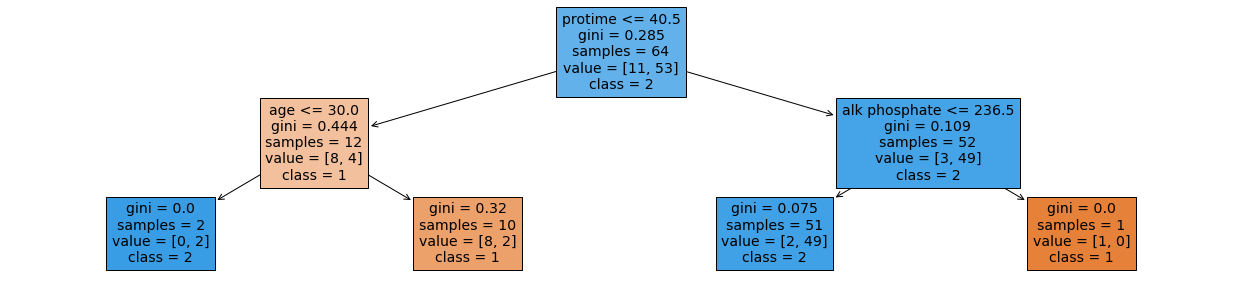

In [15]:
var_names = X_train.columns
class_names = best_dtree.classes_

plt.figure(figsize = (22,5))
tree.plot_tree(best_dtree, feature_names = var_names, class_names = class_names, filled=True)

plt.show()

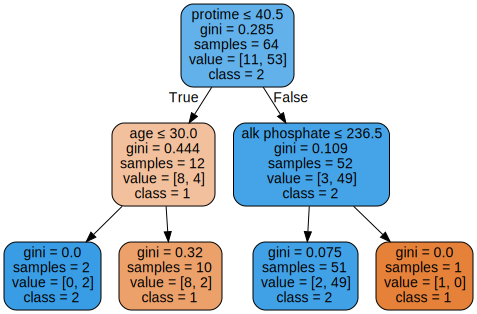

In [16]:
import graphviz

dot_data = tree.export_graphviz(best_dtree, feature_names = var_names, class_names = class_names, filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(dot_data)
graph

<AxesSubplot:title={'center':'Feature Top'}>

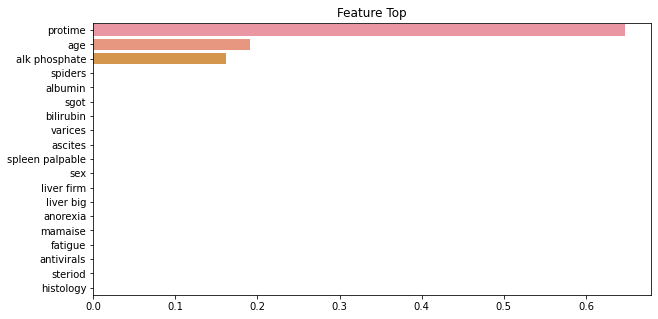

In [17]:
feature_importance_values = best_dtree.feature_importances_
feature_importance_values_s = pd.Series(feature_importance_values, index = X_train.columns)

feature_importance_sort = feature_importance_values_s.sort_values(ascending=False)

import seaborn as sns

plt.figure(figsize=(10,5))
plt.title('Feature Top')
sns.barplot(x=feature_importance_sort, y=feature_importance_sort.index)

### 실습 4: 최적 트리 모델을 post-pruning하고, post-pruning된 트리 모델 출력(이미지에 변수 이름과 class가 모두 있어야 함)
#### (test accuracy가 높으면서, node개수와 tree depth가 작은 alpha를 찾고, 해당 alpha에 해당하는 트리 모델 출력하는 실습 )

In [18]:
path = best_dtree.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

print(ccp_alphas)
print(impurities)

[0.         0.02829233 0.03333333 0.11299329]
[0.11004902 0.13834135 0.17167468 0.28466797]


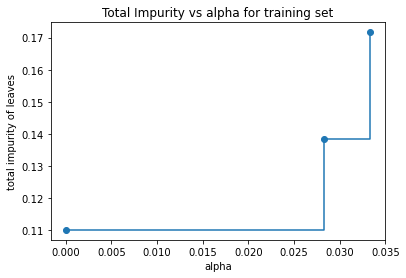

In [19]:
fig, ax = plt.subplots()

ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle = 'steps-post')
ax.set_xlabel("alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs alpha for training set")
plt.show()

In [20]:
dtree_list = []

for ccp_alpha in ccp_alphas:
    dtree_alpha = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    dtree_alpha.fit(X_train,y_train)
    dtree_list.append(dtree_alpha)

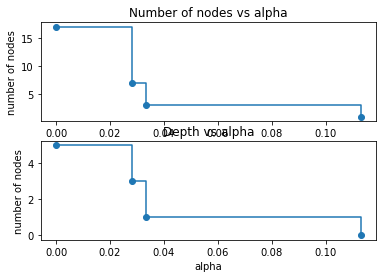

In [21]:
node_counts = [tree_alpha.tree_.node_count for tree_alpha in dtree_list]
depth = [tree_alpha.tree_.max_depth for tree_alpha in dtree_list]

fix, ax = plt.subplots(nrows=2,ncols=1)

ax[0].plot(ccp_alphas, node_counts, marker='o',drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, depth, marker='o',drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("number of nodes")
ax[1].set_title("Depth vs alpha")

fig.tight_layout()
plt.show()

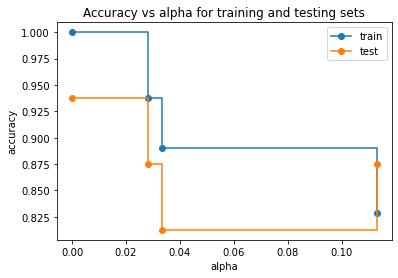

In [26]:
train_scores = [tree_alpha.score(X_train, y_train) for tree_alpha in dtree_list]
test_scores = [tree_alpha.score(X_test, y_test) for tree_alpha in dtree_list]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker = "o", label = "train", drawstyle = "steps-post")
ax.plot(ccp_alphas, test_scores, marker = "o", label = "test", drawstyle = "steps-post")
ax.legend()
plt.show()

Index(['age', 'sex', 'steriod', 'antivirals', 'fatigue', 'mamaise', 'anorexia',
       'liver big', 'liver firm', 'spleen palpable', 'spiders', 'ascites',
       'varices', 'bilirubin', 'alk phosphate', 'sgot', 'albumin', 'protime',
       'histology'],
      dtype='object')
['1' '2']


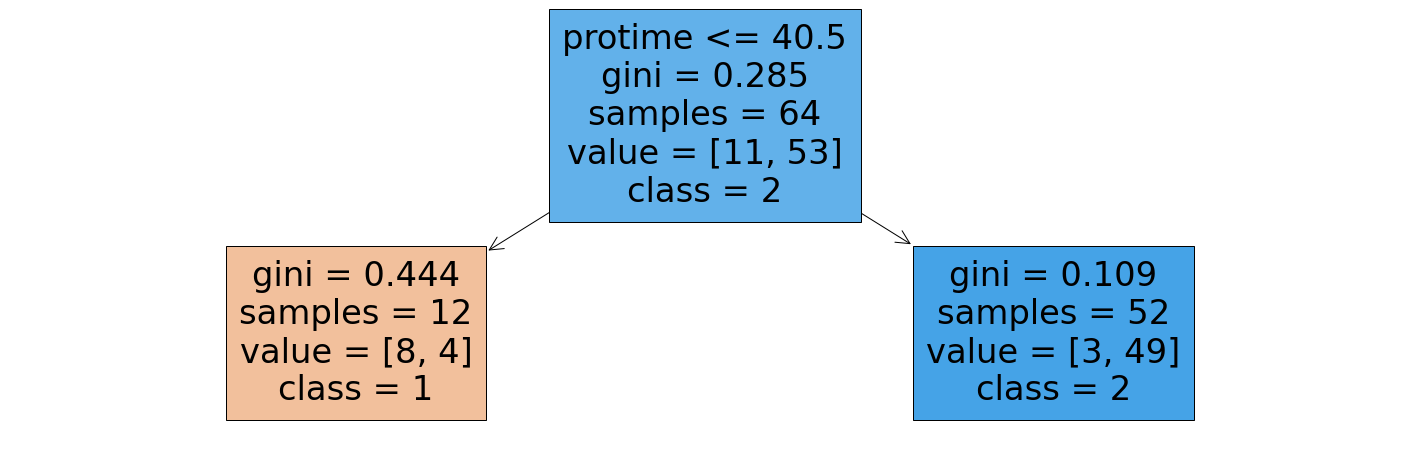

In [25]:
var_names = X_train.columns
print(var_names)

class_names = dtree_list[1].classes_
print(class_names)

plt.figure(figsize = (25,8))
tree.plot_tree(dtree_list[2], feature_names=var_names, class_names=class_names,filled=True)
plt.show()